## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].sum()/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
mismatch1 = df.query('group == "treatment" and landing_page == "old_page"').count()
mismatch2 = df.query('group == "control" and landing_page == "new_page"').count()
mismatch1 + mismatch2

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
sum(df.isnull().values.any(axis=1))


0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#Creating new dataset that meets specifications
df2 = df
df2 = df.drop(df[(df['group'] == "treatment") & (df['landing_page'] == "old_page")].index)
df2 = df2.drop(df[(df['group'] == "control") & (df['landing_page'] == "new_page")].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
#number of user_ids
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
#repeated user_id
df2[df2['user_id'].duplicated() == True].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
#row of repeated user_id
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
#remove duplicated row
df2.drop(df2[df2['user_id'].duplicated() == True].index, inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
#probability of conversion regardless of the page (old/new)
df2['converted'].sum()/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
#probability of conversion for control group
df2.query('group == "control"').converted.sum()/df2.query('group == "control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
#probability of conversion for treatment group
df2.query('group == "treatment"').converted.sum()/df2.query('group == "treatment"').shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
#probability of receiving the new page
df2.query('landing_page == "new_page"').user_id.count()/df2.shape[0]

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

According to (d) about half of the individuals in consideration received the new page. Thus we have a good proportion to be able to make comparisons. Conversion rate for the control group is slightly higher than for the treatment group. I wouldn't say that the new treatment page leads to more conversions. In fact, results seem to point out the opposite. However, the conversion probabilities are very close and there might be some factors influencing them that could easily change the probabilities and lead to opposite results. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null hypothesis: 𝑝𝑜𝑙𝑑 - 𝑝𝑛𝑒𝑤 >= 0
Alternative hypothesis: 𝑝𝑜𝑙𝑑 - 𝑝𝑛𝑒𝑤 < 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
#conversion rate: new page
conv_rate = df2["converted"].sum()/df2.shape[0]
conv_rate

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
# under the null, p_new = p_old
#conversion rate: old page
conv_rate


0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [46]:
#number of individuals in treatment group
n_new = df2.query('group == "treatment"')["user_id"].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [47]:
#number of individuals in control group
n_old = df2.query('group == "control"')["user_id"].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
#n_new simulations
new_page_converted = np.random.binomial(1, conv_rate, size=n_new)
print(new_page_converted)
new_page_converted.sum()/len(new_page_converted)

[0 0 0 ..., 0 0 0]


0.11988163237216984

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
#n_old simulations
old_page_converted = np.random.binomial(1, conv_rate, size=n_old)
print(old_page_converted)

[0 0 1 ..., 0 0 0]


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [45]:
p_old = df2['converted'].mean()
p_new = df2['converted'].mean()
diff = p_new - p_old
diff


0.0

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
#simulate 10000 p_new - p_old
p_diffs, old_df, new_df = [],[],[]
for i in range(10000):
    old_df = np.random.binomial(1, conv_rate, size=n_old)
    new_df = np.random.binomial(1, conv_rate, size=n_new)
    old_p = old_df.mean()
    new_p = new_df.mean()
    p_diffs.append(new_p - old_p)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([    7.,    58.,   442.,  1507.,  2801.,  2963.,  1626.,   504.,
           85.,     7.]),
 array([ -4.88188828e-03,  -3.91695181e-03,  -2.95201534e-03,
         -1.98707888e-03,  -1.02214241e-03,  -5.72059425e-05,
          9.07730524e-04,   1.87266699e-03,   2.83760346e-03,
          3.80253993e-03,   4.76747639e-03]),
 <a list of 10 Patch objects>)

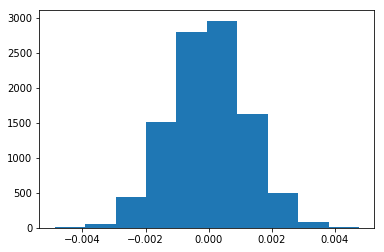

In [26]:
#Plot histogram
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [48]:
#Calculate p-value
p_diffs = np.random.binomial(n_new, p_new, 10000)/n_new - np.random.binomial(n_old, p_old, 10000)/n_old
obs_diff = df2['converted'][df2['group'] == 'treatment'].mean() - df2['converted'][df2['group'] == 'control'].mean()
len(p_diffs[p_diffs > obs_diff])/len(p_diffs)

0.9032

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

In j., I calculated the p-value. This is the probability of getting a higher conversion rate than that that we observed in ab_data.csv. The p-value is much higher than 0.05. This means that we fail to reject the null hypothesis, that states that the conversion rate of the old page is higher than that of the new page. This is, there is statistical evidence that the conversion rate for the old page is higher than for the new page. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
#Alternative way to get p-value and z-score
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')["converted"].sum()
convert_new = df2.query('landing_page == "new_page"')["converted"].sum()
n_old = df2.query('landing_page == "old_page"')["user_id"].count()
n_new = df2.query('landing_page == "new_page"')["user_id"].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [29]:
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])

stats = sm.stats.proportions_ztest(count, nobs, value=None, alternative='smaller', prop_var=False)
stats

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score tells us the deviation of the observation from the mean. As in j. and k., the p-value is much higher than 0.05, meaning that we fail to reject the null hypothesis. This is, there is statistical evidence that the conversion for the old page is higher than for the new page.  

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

We should use a logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
#Create intercept and dummy columns
df2["intercept"] = 1
df2[['control','ab_page']] = pd.get_dummies(df['group'])
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [31]:
#Regression model
logm = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
res = logm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-16 14:47 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

 The p-value associated with **ab_page** is 0.2161, which means that we fail to reject the null hypothesis. In this case, we want to know if this variable (**ab_page**) helps to explain the varaible **converted**. This is, the null hypotheses is that the coefficient of **ab_page** is zero and the alternative is that it is different from zero. While before, in Part II, we instead compared the convertion of the two groups (tratment+new_page and control+old_page) and tried to assess if there was a significant difference in convertion between them.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The results show us that the new page doesn't seem to lead to higher conversion than the old page. This might not be due to the new page itself being worse, but, for example, due to initial skepticism of people to navigate in the new page or other differences between the individuals in the treatment and control group. There could also be some issue with the new page that are influencing the conversion rate and distorting results. There might be some disadvantages to adding additional terms to the regression model. For example, if we add a new variable that is very correlated to one already in the model this might lead to misleading results.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [33]:
#Create intercept, dummies and fit regression
df_countries = pd.read_csv("countries.csv")
df3 = df2.merge(df_countries, on="user_id")
df3["intercept"] = 1
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
logm = sm.Logit(df3['converted'], df3[['intercept','UK','CA']])
res = logm.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-16 14:47 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
==================================================================

"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [54]:
df3['UK_ab_page'] = df3['UK']*df3['ab_page']
df3['CA_ab_page'] = df3['CA']*df3['ab_page']
logit3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])

results = logit3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-16 14:59 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

Conclusion: both for the regressions that consider the country and page indvidually and for this one that considers
them together, the p-values are bigger than 0.05. This means that we fail to reject the null hypothesis. This is,
there is not statistical evidence to say that the coefficients of ab_page and countries should be different from zero.

In [35]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0